# Inpainting Project

#### Imports

In [44]:
#-*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
import numpy as np
#import seaborn as sns; sns.set()

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (confusion_matrix,
                             accuracy_score)
from sklearn.grid_search import GridSearchCV
from sklearn.manifold import Isomap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import (LinearRegression, 
                                  RidgeClassifierCV, 
                                  LassoCV)

from tqdm import trange

from appendix_figures import *

In [4]:
train_file = "USPS/USPS_train.txt"
test_file = "USPS/USPS_test.txt"

## Préambule : régression linéaire, régression ridge et LASSO

### Fonctions de base pour manipuler les données USPS

In [5]:
def load_usps(fn):
    """ Lire un fichier USPS """

    with open(fn, "r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split()) > 2]
    tmp = np.array(data)

    # Retourne la seconde colonne jusqu'à la dernière tmp[:,1:], ainsi que
    # la première colonne tmp[:,0]
    return tmp[:, 1:], tmp[:, 0].astype(int)


def extract_one_number(number, datax, datay):
    
    indexes = np.hstack(np.where(datay == number)[0])
    return datax[indexes]


def extract_usps(fichier, firstclass, secondclass):
    """ Permet de construire un ensemble de données datax, datay avec les
        données USPS, juste en lui spécifiant en paramètre:
        :param fichier: le fichier,
        :param firstclass: le premier chiffre dont on veut extraire les données
        :param secondclass: le second chiffre.
        :return: datax, datay
    """

    pixels, numbers = load_usps(fichier)
    indexes69 = np.hstack(
        np.where(
            numbers == i)[0] for i in (
            firstclass,
            secondclass))
    pixels69 = pixels[indexes69]
    numbers69 = numbers[indexes69]
    pixels69y = np.ones(pixels69.shape[0])

    for i in range(numbers69.shape[0]):
        if numbers69[i] == firstclass:
            pixels69y[i] = -1
        else:
            pixels69y[i] = 1

    return pixels69, pixels69y

## Visualiser la structure des chiffres

In [6]:
# Load data
trainx, trainy = load_usps("USPS/USPS_train.txt")
testx, testy = load_usps("USPS/USPS_test.txt")

print("trainx shape : {}".format(trainx.shape))
print("testx shape: {}".format(testx.shape))

trainx shape : (7291, 256)
testx shape: (2007, 256)


Les données de train de USPS consiste en $7291$ images de $256$ pixels $(16x16)$ chacune, et celles de test en $2007$ images.

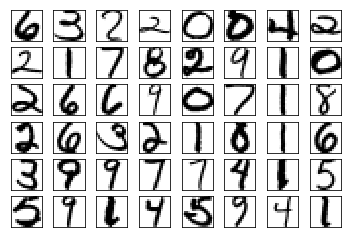

In [7]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(trainx[26 * i].reshape(16, 16), cmap='gray_r')

Les données USPS contiennent une variété d'écritures manuscrites. Afin d'en avoir une idée, nous en avons afficher ci-dessus quelques unes.

Lorsque nous faisions les TMEs, nous nous sommes acharnés à vouloir afficher les données USPS en $2$ dimensions, mais cela nous était impossible vu le nombre de dimensions et la manière dont nous procédions (sans réduction des dimensions). 

Nous avons par la suite découvert le **manifold learning**, qui, par ces multiples estimateurs non supervisés, projette des données de très hautes dimensions en de faibles dimensions. Ainsi, nous avons pu visualiser les données USPS en $2$ dimensions.

Ici, pour la vitesse d'exécution, nous utiliserons $1/4$ des données, ce qui fait environ $1820$ points.

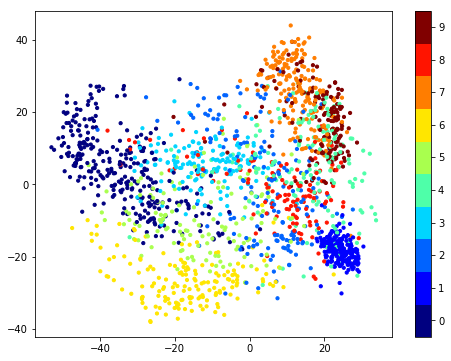

In [8]:
# Seulement le 1/4 des données
data = trainx[::4]
labels = trainy[::4]

# Projection des données en 2 dimensions
model = Isomap(n_components=2)
proj = model.fit_transform(data)

# Affichage
plt.figure(figsize=(8,6))
plt.scatter(proj[:, 0], proj[:, 1], s=10, c=labels, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)


Cette figure nous permet de comprendre comment sont reliées les données. Par exemple, nous pouvons en déduire que les chiffres $6$ et $1$ n'ont la plupart du temps pas beaucoup de pixels en commun, pour le chiffre $1$ d'ailleurs, les différentes écritures manuscrites se ressemblent beaucoup vu le petit groupement de points qui le répresente.

Avec la masse de points, nous avons néamoins un peu de difficultés de visualiser les données, c'est pourquoi ci-dessous, nous avons zoomé un peu plus sur chaque chiffre avant d'observer les différentes écritures manuscrites pour chacun d'eux.

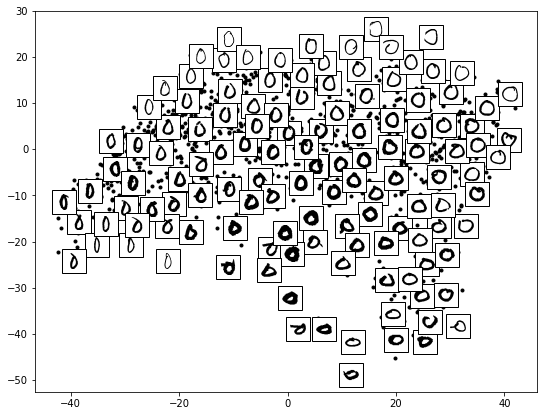

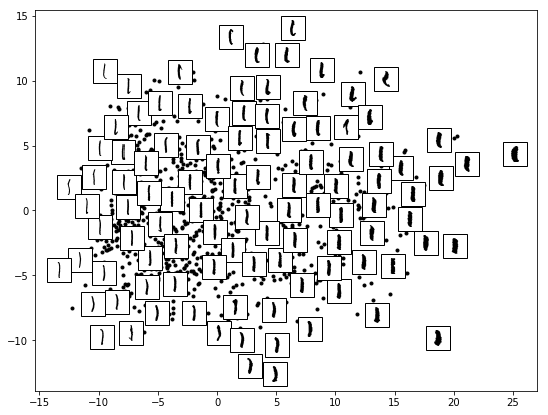

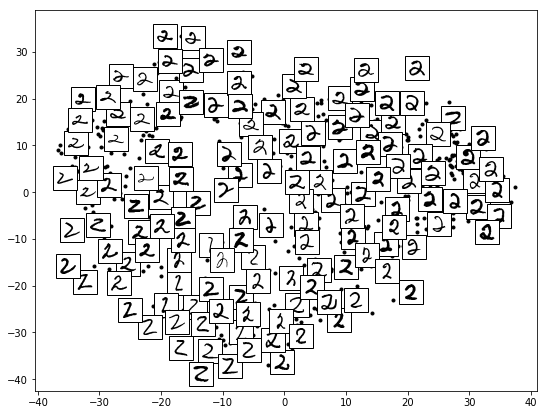

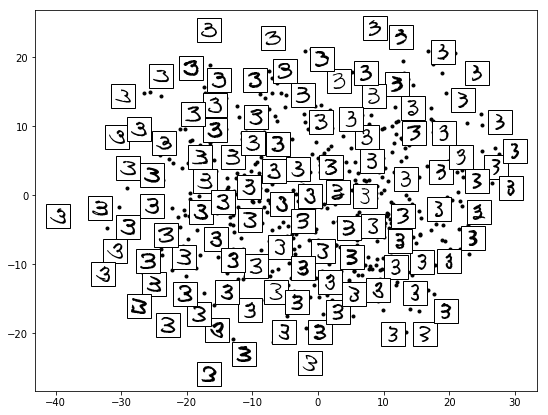

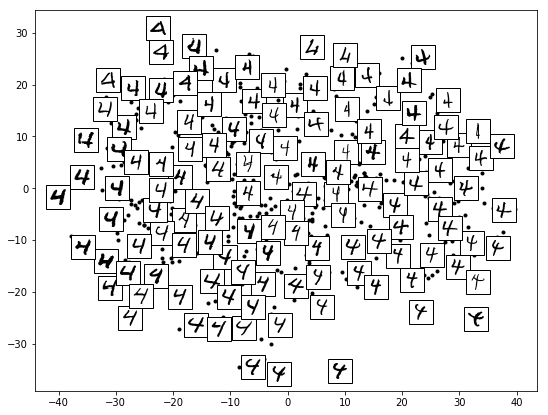

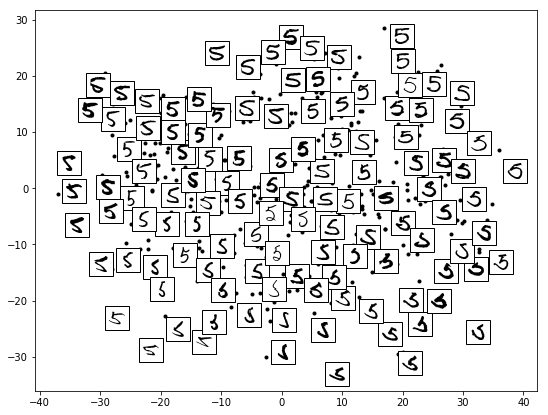

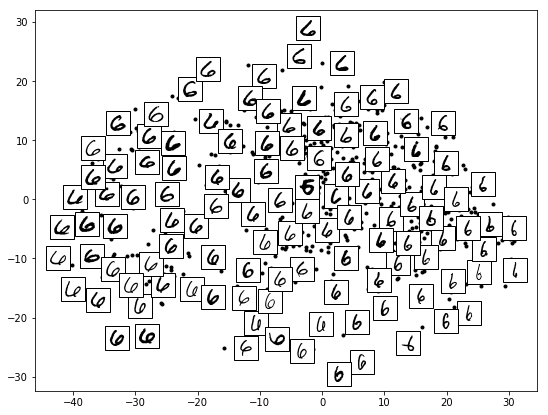

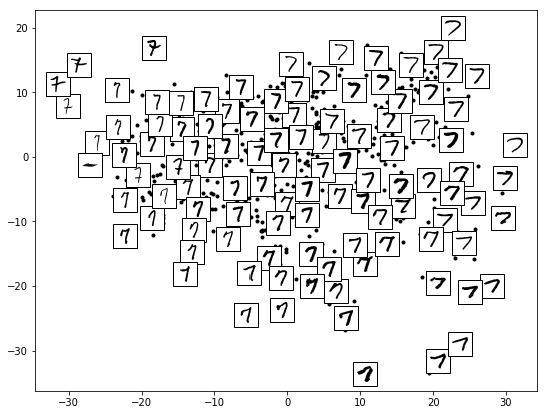

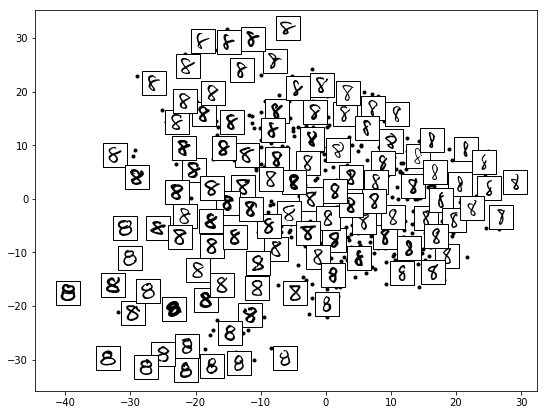

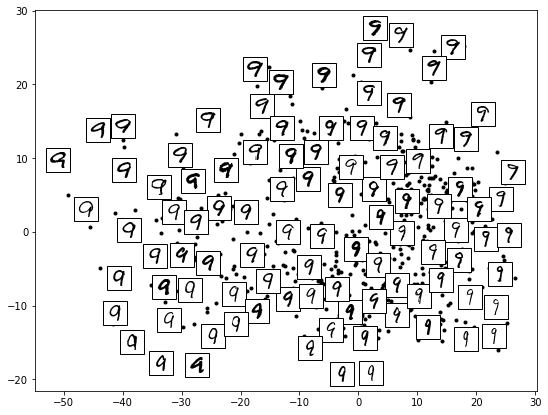

In [9]:
# Afficher en zoom les différences manuscrites pour chaque chiffre

for number in range(10):
    # Extraction du nombre number
    data = extract_one_number(number, trainx, trainy)
    
    # Affichage des différentes écritures manuscrites de ce nombre 
    fig, ax = plt.subplots(figsize=(9, 7))
    model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
    plot_components(data, model, images=data.reshape((-1, 16, 16)),
                    ax=ax, thumb_frac=0.05, cmap='gray_r')

Ainsi, nous remarquons que pour certains chiffres comme $1$, $0$, la principale différence réside d'une part en l'orientation, si *italique* ou non et d'autre part en se déplaçant d'un côté à l'autre de la figure, nous traversons les différentes mises en forme, du plus gras au moins. Aussi, certains chiffres se retrouvent isolés de leurs voisins, ces derniers sont pour la majorité des cas, des écritures manuscrites qui n'ont pas beaucoup de ressemblance avec le chiffre en question (vilaines écritures). Des $7$ qui ressemblent plus à des $1$ ou des $5$ qui ressemblent à des $s$, etc...

Ceci, en soi-même n'est pas très important pour la classification que nous réaliserons un peu plus loin, mais nous aide à comprendre les données, en l'occurrence les principales différences entre les chiffres, comment sont ils reliés, quels sont ceux qui se ressemblent, et plus en profondeur, quels sont ceux arborant moins de différence entre les écritures manuscrites et ceux avec plus de différence. 

In [10]:
def score(testy, testy_predict):
    """ Return le score étant donné les labels initiaux et les labels prédits """
    
    return np.mean((np.sign(testy_predict) == testy[:, np.newaxis]))

In [11]:
class1, class2 = 6, 9
trainx, trainy = extract_usps(train_file, class1, class2)
testx, testy = extract_usps(test_file, class1, class2)

In [12]:
linearReg_clf = LinearRegression(n_jobs=-1)

linearReg_clf.fit(trainx, trainy)

print("Regression linéaire \n===================\n")
print("Ensemble de paramètres :")
print("======================")
print(linearReg_clf.get_params())

testy_predict = linearReg_clf.predict(testx)

print("\nScore de bonne classification :")
print("=============================")
print("{:.2%}".format(score(testy, testy_predict)))

Regression linéaire 

Ensemble de paramètres :
{'copy_X': True, 'normalize': False, 'n_jobs': -1, 'fit_intercept': True}

Score de bonne classification :
50.03%


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Ensemble de paramètres parmis lesquels recherchés :
{'cv': None, 'alphas': (0.01, 0.1, 1, 10, 100, 1000), 'normalize': False, 'class_weight': None, 'fit_intercept': True, 'scoring': None}

Alpha sélectionné :
100.0

Score de bonne classification :
99.71%


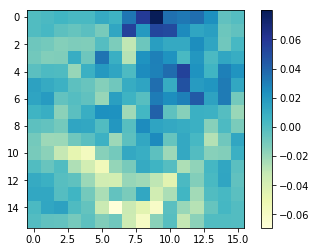

In [13]:
ridge_clf = RidgeClassifierCV(alphas=(0.01, 0.1, 1, 10, 100, 1000))

ridge_clf.fit(trainx, trainy)

print("Ensemble de paramètres parmis lesquels recherchés :")
print("==================================================")
print(ridge_clf.get_params())

print("\nAlpha sélectionné :")
print("===================")
print(ridge_clf.alpha_)

print("\nScore de bonne classification :")
print("=============================")
print("{:.2%}".format(ridge_clf.score(testx, testy)))

# Affichage de la matrice de poids
show_usps(ridge_clf.coef_)

Ensemble de paramètres parmis lesquels recherchés :
{'copy_X': True, 'cv': None, 'n_alphas': 100, 'alphas': (0.01, 0.1, 1, 10, 100, 1000), 'max_iter': 1000, 'normalize': False, 'n_jobs': 1, 'precompute': 'auto', 'fit_intercept': True, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False, 'positive': False, 'random_state': None, 'eps': 0.001}

Alpha sélectionné :
0.01

Score de bonne classification :
92.30%


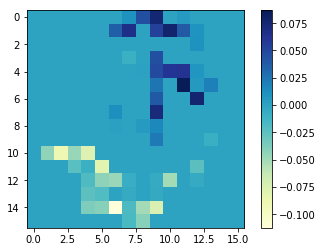

In [14]:
lasso_clf = LassoCV(alphas=(0.01, 0.1, 1, 10, 100, 1000))
lasso_clf.fit(trainx, trainy)

print("Ensemble de paramètres parmis lesquels recherchés :")
print("==================================================")
print(lasso_clf.get_params())

print("\nAlpha sélectionné :")
print("===================")
print(lasso_clf.alpha_)

print("\nScore de bonne classification :")
print("=============================")
print("{:.2%}".format(lasso_clf.score(testx, testy)))

# Affichage de la matrice de poids
show_usps(lasso_clf.coef_)

## LASSO et Inpainting

In [94]:
def normalize(im, a, b):
    """ Normalize the matrix between 0 and 1 """
    
    lmin = float(im.min())
    lmax = float(im.max())
    
    return a + ((im - lmin) * (b - a)/(lmax - lmin))

def read_im(fn):
    """ Read an image and transform it to HSV """

    im = plt.imread(fn)
    print("Original Image\n==============")
    plt.imshow(im)
    print(im[:1])
    return rgb_to_hsv(im[:,:,:3])

def show_im(im):
    """ Plot the image """
    
    plt.figure()
    plt.imshow(im)    
    
def transform_to_2D(im):
    """ Transform matrix 3D to 2D by """
    
    return np.array([np.ravel(im[i]) for i in range(im.shape[0])])

def get_patch(i, j, h, im):
    """ Return a patch given i and j coordonate and the height h """
    
    return im[int(i - (h/2)) : int(i + (h/2)), int(j - (3 * h/2)) : int(j + (3 * h/2))]
    

Original Image
[[[ 84 158 221]
  [ 31 104 173]
  [  3  74 154]
  ..., 
  [  0  45  65]
  [  0  46  66]
  [  1  48  68]]]


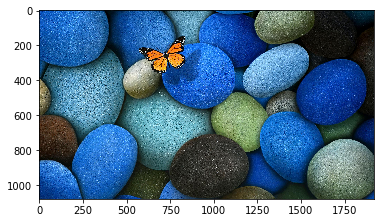

In [61]:
im = read_im("Images/papillon.jpg")

Transformed to HSV
[[   0.57664233    0.61990952  221.        ]
 [   0.5809859     0.82080925  173.        ]
 [   0.58830023    0.98051947  154.        ]
 ..., 
 [   0.55128205    1.           65.        ]
 [   0.55050504    1.           66.        ]
 [   0.54975122    0.9852941    68.        ]]


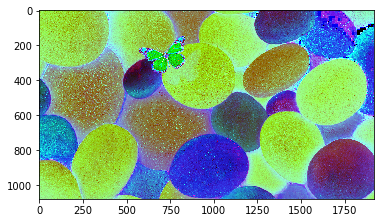

In [62]:
print("Transformed to HSV\n==================")
print(im[0])
show_im(im)

Normalized between 0 and 1
(1080, 1920, 3)


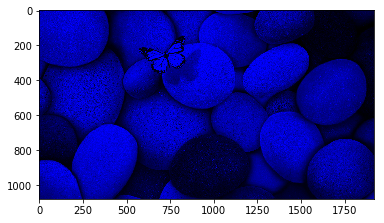

In [71]:
print("Normalized between 0 and 1\n=======================")
im_norm = normalize(im, 0, 1)
print(im_norm[0])
show_im(im_norm)


[ 0.00226134  0.00243102  0.86666667 ...,  0.00215589  0.0038639
  0.26666668]


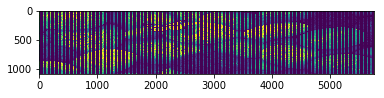

In [72]:
print("\n=======================")
im_norm_2D = transform_to_2D(im_norm)
print(im_norm_2D[0])
show_im(im_norm_2D)

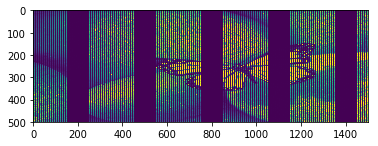

In [101]:
patch = get_patch(250, 2000, 500, im_norm_2D)
show_im(patch)